In [1]:
# Mounting Gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/deep_learning/text_in_img

/content/gdrive/MyDrive/deep_learning/text_in_img


# Data Preparation

In [3]:
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling1D

## Image Preprocessing

In [49]:
# Load and preprocess images
cover_images = []
cover_img_paths = glob.glob("secret_img/*")

input_shape = (64, 64, 3)

for cover_path in sorted(cover_img_paths):
    cover_image = Image.open(cover_path).convert('RGB').resize(input_shape[:2])
    cover_images.append(np.asarray(cover_image))

def normalize_images(images):
    return np.array([np.array(img) / 255.0 for img in images])

cover_images = normalize_images(cover_images)

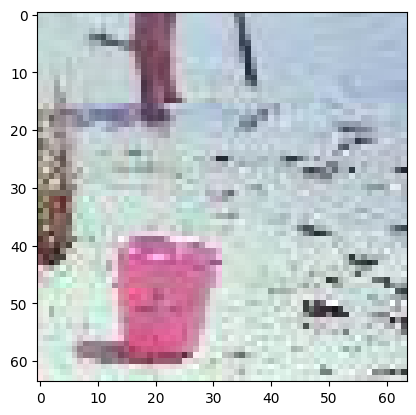

In [50]:
import matplotlib.pyplot as plt 
plt.imshow(cover_images[0,:,:,:])

In [6]:
cover_images.shape

(99, 64, 64, 3)

## Text Preprocessing

In [7]:
import re

# Load and preprocess text data
text_data = []
text_paths = glob.glob('text/*')

for text_path in sorted(text_paths):
    with open(text_path, 'r') as file:
        text = file.read().lower()
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
        text = ' '.join(text.split()[:2])
        text_data.append(text)

max_len = max([len(text) for text in text_data])

In [8]:
# Tokenize text data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(text_data)
encoded_texts = tokenizer.texts_to_sequences(text_data)

In [9]:
# Checking the first example raw text
text_data[:10]

['drug transaction',
 'instruction are',
 'company is',
 'look for',
 'the water',
 'a secret',
 'dead people',
 'access the',
 'life is',
 'download the']

In [10]:
# checking encoded text
print(encoded_texts[0])

[17, 7, 19, 14, 2, 4, 7, 8, 9, 5, 8, 12, 4, 3, 6, 9]


In [11]:
# Checking number of unique characters in the text in addition to space character
len(tokenizer.word_index)

24

In [12]:
# One-hot encode text data
num_chars = len(tokenizer.word_index)+1
encoded_texts = tf.keras.preprocessing.sequence.pad_sequences(encoded_texts, maxlen=max_len, padding='post')
one_hot_texts = to_categorical(encoded_texts, num_classes=num_chars)

In [13]:
# prepadding
encoded_texts[0]

array([17,  7, 19, 14,  2,  4,  7,  8,  9,  5,  8, 12,  4,  3,  6,  9,  0,
        0], dtype=int32)

In [14]:
one_hot_texts.shape

(99, 18, 25)

In [15]:
one_hot_texts[0,:,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

## Splitting the data

In [16]:
# Split the dataset into training and validation sets
X_cover_train, X_cover_val, X_secret_train, X_secret_val = train_test_split(cover_images, one_hot_texts, test_size=0.2, random_state=42)

In [17]:
# Create TensorFlow Dataset objects
BATCH_SIZE = 16
BUFFER_SIZE = 100

def create_dataset(X_cover, X_secret, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(((X_cover, X_secret), (X_cover, X_secret)))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_cover_train, X_secret_train, BATCH_SIZE, BUFFER_SIZE)
val_dataset = create_dataset(X_cover_val, X_secret_val, BATCH_SIZE, BUFFER_SIZE)

## Model Building

### Hiding Network

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, Concatenate
from tensorflow.keras import Model, Input

In [19]:
# Hiding network
def hiding_network(input_shape, text_shape):
    cover_input = layers.Input(input_shape)
    secret_input = layers.Input(text_shape)

    x = layers.GlobalAveragePooling1D()(secret_input)

    # x = layers.Flatten()(secret_input)

    # x = layers.GlobalMaxPooling1D()(secret_input)

    # x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(secret_input)
    # x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(input_shape[0] * input_shape[1] * input_shape[2])(x)
    x = layers.Reshape((input_shape[0], input_shape[1], input_shape[2]))(x)

    x = layers.Concatenate()([cover_input, x]) # concatenating cover image and text, output shape is (224,224,3+3)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    return Model(inputs=[cover_input, secret_input], outputs=x)

In [20]:
text_shape = (max_len, num_chars)
hiding_net = hiding_network(input_shape, text_shape)

In [21]:
hiding_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 18, 25)]     0           []                               
                                                                                                  
 global_average_pooling1d (Glob  (None, 25)          0           ['input_2[0][0]']                
 alAveragePooling1D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 12288)        319488      ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                              

### Revealing Network

In [22]:
# Revealing network
def revealing_network(input_shape, text_shape):
    input_layer = layers.Input(input_shape)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(text_shape[0] * text_shape[1], activation='sigmoid')(x)
    x = layers.Reshape(text_shape)(x)
    
    return Model(inputs=input_layer, outputs=x)

In [23]:
revealing_net = revealing_network(input_shape, text_shape)

In [24]:
revealing_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 450)               29250     
                                                                 
 reshape_1 (Reshape)         (None, 18, 25)            0         
                                                           

### Combining Hiding Network and Revealing Network

In [25]:
# Combined model
cover_input = layers.Input(input_shape)
secret_input = layers.Input(text_shape)

hidden = hiding_net([cover_input, secret_input])
revealed = revealing_net(hidden)

combined_model = Model(inputs=[cover_input, secret_input], outputs=[hidden, revealed])

In [26]:
def cover_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def secret_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def combined_loss(y_true_cover, y_pred_cover, y_true_secret, y_pred_secret):
    cover_loss_value = cover_loss(y_true_cover, y_pred_cover)
    secret_loss_value = secret_loss(y_true_secret, y_pred_secret)
    return 1 * cover_loss_value + 1 * secret_loss_value

combined_model.compile(optimizer='adam', loss=[cover_loss,secret_loss])

## Model Training

In [27]:
# Train the model
EPOCHS = 80
combined_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/80
5/5 [==============================] - 15s 249ms/step - loss: 0.3245 - model_loss: 0.0767 - model_1_loss: 0.2478 - val_loss: 0.3173 - val_model_loss: 0.0757 - val_model_1_loss: 0.2417
Epoch 2/80
5/5 [==============================] - 0s 27ms/step - loss: 0.3013 - model_loss: 0.0674 - model_1_loss: 0.2339 - val_loss: 0.2813 - val_model_loss: 0.0643 - val_model_1_loss: 0.2170
Epoch 3/80
5/5 [==============================] - 0s 26ms/step - loss: 0.2548 - model_loss: 0.0564 - model_1_loss: 0.1985 - val_loss: 0.2102 - val_model_loss: 0.0501 - val_model_1_loss: 0.1601
Epoch 4/80
5/5 [==============================] - 0s 26ms/step - loss: 0.1813 - model_loss: 0.0430 - model_1_loss: 0.1383 - val_loss: 0.1284 - val_model_loss: 0.0325 - val_model_1_loss: 0.0959
Epoch 5/80
5/5 [==============================] - 0s 30ms/step - loss: 0.1054 - model_loss: 0.0285 - model_1_loss: 0.0769 - val_loss: 0.0722 - val_model_loss: 0.0180 - val_model_1_loss: 0.0541
Epoch 6/80
5/5 [=================

### Save Model

In [ ]:
# # Saving Hiding Model

# hiding_net.save('hiding_net.h5')

In [ ]:
# # Saving Revealing Model

# revealing_net.save('revealing_net.h5')

## Model Evaluaton

In [28]:
# Evaluation
cover_batch, secret_batch = next(iter(val_dataset))[0]
hidden_batch = hiding_net.predict([cover_batch, secret_batch])
revealed_batch = revealing_net.predict(hidden_batch)

# Convert one-hot encoded text back to original text
decoded_texts = tokenizer.sequences_to_texts(np.argmax(revealed_batch, axis=-1))

for i, text in enumerate(decoded_texts[:5]):
    print(f"Original text: {text_data[i]}")
    print(f"Decoded text: {text}\n")

1/1 [==============================] - 0s 81ms/step
Original text: drug transaction
Decoded text: t o e e   i e  

Original text: instruction are
Decoded text: t o e e   i e  

Original text: company is
Decoded text: t o e e   i e  

Original text: look for
Decoded text: t o e e   i e

Original text: the water
Decoded text: t o e e   i e  



## Visualizing Stegano images

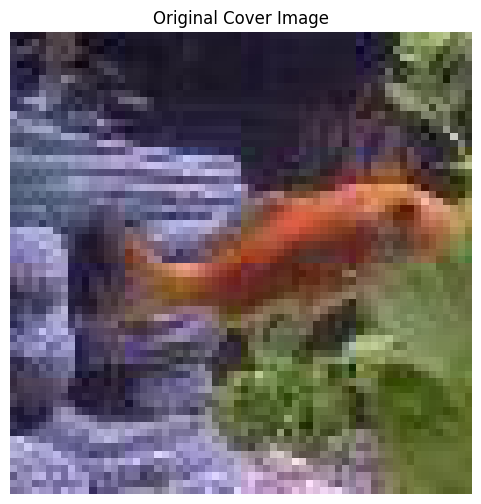

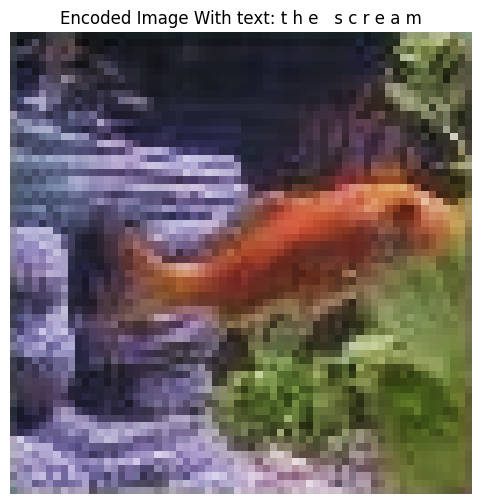

In [ ]:
import matplotlib.pyplot as plt

# Choose an index of the image you want to visualize
image_idx = 3

# Get the image from the hidden_batch
encoded_image = hidden_batch[image_idx]

decod_res = tokenizer.sequences_to_texts(np.argmax(secret_batch, axis=-1))
title = decod_res[image_idx]

# Denormalize the image
denormalized_image = (encoded_image * 255).astype(np.uint8)

# Plot the original cover image
plt.figure(figsize=(6, 6))
plt.title("Original Cover Image")
plt.imshow(cover_batch[image_idx])
plt.axis("off")
plt.show()

# Plot the encoded image
plt.figure(figsize=(6, 6))
plt.title(f"Encoded Image With text: {title}")
plt.imshow(denormalized_image)
plt.axis("off")
plt.show()

## Saving stegano Images and corresponding original Images

In [ ]:
pwd

'/content/gdrive/MyDrive/deep_learning/text_in_img'

In [ ]:
%cd /content/gdrive/MyDrive/deep_learning/text_in_img/results

/content/gdrive/MyDrive/deep_learning/text_in_img/results


In [ ]:
import matplotlib.pyplot as plt
 

for index in range(10):
  # Get the image from the hidden_batch
  encoded_image = hidden_batch[index]

  decod_res = tokenizer.sequences_to_texts(np.argmax(secret_batch, axis=-1))
  title = decod_res[index]

  # Denormalize the image
  denormalized_image = (encoded_image * 255).astype(np.uint8)
  # Plot the original cover image
  plt.figure(figsize=(6, 6))
  plt.title(f"Original Cover Image {index}")
  plt.imshow(cover_batch[index])
  plt.axis("off")
  plt.savefig(f'original_cover_img_{index}.jpg')

  # Plot the encoded image
  plt.figure(figsize=(6, 6))
  plt.title(f"Encoded Image With text: {title}")
  plt.imshow(denormalized_image)
  plt.axis("off")
  plt.savefig(f'Stego Image {index}.jpg')

## Comparision of LSB stegano images and encoder stegano images

In [29]:
%cd /content/gdrive/MyDrive/deep_learning/text_in_img

/content/gdrive/MyDrive/deep_learning/text_in_img


In [55]:
from PIL import Image

# Function to convert text to binary
def text_to_binary(text):
    binary = ''.join(format(ord(i), '08b') for i in text)
    return binary

# Function to hide the text in the image using LSB algorithm
def hide_text_in_image_LSB(image_path, text):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image to RGB format
    img = img.convert('RGB')
    # Get the pixel map of the image
    pixel_map = img.load()
    # Convert the text to binary
    binary_text = text_to_binary(text)
    # Get the length of the binary text
    text_length = len(binary_text)
    # Get the maximum number of bits that can be hidden in the image
    max_bits = img.size[0] * img.size[1] * 3
    if text_length > max_bits:
        raise ValueError('Text too long to hide in image')
    # Add a sentinel value to the binary text to indicate the end of the text
    binary_text += '1111111111111110'
    # Get the current bit position
    bit_pos = 0
    # Iterate over each pixel in the image
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            # Get the RGB values of the current pixel
            r, g, b = pixel_map[x, y]
            # Convert the RGB values to binary
            r_binary = format(r, '08b')
            g_binary = format(g, '08b')
            b_binary = format(b, '08b')
            # Modify the LSB of the RGB values with the bits of the binary text
            if bit_pos < text_length:
                r_binary = r_binary[:-1] + binary_text[bit_pos]
                bit_pos += 1
            if bit_pos < text_length:
                g_binary = g_binary[:-1] + binary_text[bit_pos]
                bit_pos += 1
            if bit_pos < text_length:
                b_binary = b_binary[:-1] + binary_text[bit_pos]
                bit_pos += 1
            # Convert the modified binary values back to decimal values
            r = int(r_binary, 2)
            g = int(g_binary, 2)
            b = int(b_binary, 2)
            # Update the pixel map with the modified RGB values
            pixel_map[x, y] = (r, g, b)
            # Break out of the loop if all bits of the binary text have been hidden
            if bit_pos >= text_length:
                break
        if bit_pos >= text_length:
            break
    return img

In [56]:
lsb_encoded_img = []
input_shape = (64,64,3)

for img_path, text_path in zip(sorted(cover_img_paths)[:10],sorted(text_paths)[:10]):
    with open(text_path, 'r') as file:
        text = file.read()
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
        img = hide_text_in_image_LSB(img_path, text)
        img = img.convert('RGB').resize(input_shape[:2])
        lsb_encoded_img.append(np.array(img))

In [57]:
# Generating stegano images that has text embedded in it

cover_batch = cover_images[:10,:,:,:]
secret_batch = one_hot_texts[:10,:,:]

In [58]:
cover_batch.shape, secret_batch.shape

((10, 64, 64, 3), (10, 18, 25))

In [59]:
hidden_batch = hiding_net.predict([cover_batch, secret_batch])
hidden_batch = (hidden_batch * 255).astype(np.uint8)

1/1 [==============================] - 0s 32ms/step


In [60]:
hidden_batch.shape

(10, 64, 64, 3)

In [61]:
lsb_encoded_img = np.array(lsb_encoded_img)
lsb_encoded_img.shape

(10, 64, 64, 3)

In [62]:
import cv2
import numpy as np

def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = cv2.GaussianBlur(img1 * img1, (11, 11), 1.5) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(img2 * img2, (11, 11), 1.5) - mu2_sq
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean(axis=(0, 1))

In [63]:
cover_img = cover_images*255.0

### Performing on Encoder Stego images

In [64]:
# Read the images
original_image = cover_img[1,:,:,:]
stegano_image = hidden_batch[1,:,:,:]

# Calculate SSIM
ssim_value = ssim(original_image, stegano_image)
print(f'SSIM between Cover Image 1 and Encoded Stego Image 1: {ssim_value}')

SSIM between Cover Image 1 and Encoded Stego Image 1: [0.97152185 0.97471811 0.94560629]


In [65]:
# Read the images
original_image = cover_img[2,:,:,:]
stegano_image = hidden_batch[2,:,:,:]

# Calculate SSIM
ssim_value = ssim(original_image, stegano_image)
print(f'SSIM between Cover Image 2 and Encoded Stego Image 2: {ssim_value}')

SSIM between Cover Image 2 and Encoded Stego Image 2: [0.97731962 0.95395854 0.90844438]


### Performing on LSB Stego Images

In [66]:
# Read the images
original_image = cover_img[1,:,:,:]
stegano_image = lsb_encoded_img[1,:,:,:]

# Calculate SSIM
ssim_value = ssim(original_image, stegano_image)
print(f'SSIM between Cover Image 1 and LSB Stego Image 1:  {ssim_value}')

SSIM between Cover Image 1 and LSB Stego Image 1:  [0.99999178 0.99999342 0.99999409]


In [67]:
# Read the images
original_image = cover_img[2,:,:,:]
stegano_image = lsb_encoded_img[2,:,:,:]

# Calculate SSIM
ssim_value = ssim(original_image, stegano_image)
print(f'SSIM between Cover Image 2 and LSB Stego Image 2:  {ssim_value}')

SSIM between Cover Image 2 and LSB Stego Image 2:  [0.9999624  0.99995595 0.99995717]
